# Objetivos:
**Agrupar datos por su similaridad para caracterizar los distintos grupos  de datos formados**. La agrupación se realiza por estaciones.

**Fun Fact para visualización:** Al juntar cada dato por columna, se podria ver como una imagen, si se normaliza cada valor para que esté entre 0 y 255 (o 0 y 1), podría ser interesante ver esas evoluciones con un heatmap donde cada fila sea la cantidad de salidas en un intervalo especifico y cada columna representa el día del mes en el que se tomó la muestra

- Hacer un análisis descriptivo y estadístico de los datos por día, mes  (temporal, como comparativo entre estaciones o Zonas)
    - Tendencia, estacionalidad, periodicidad
    - Graficas de autocorrelación
    - Suavizado de las gráficas
- Agrupar salidas acorde a su comportamiento.
    - Entre mismos días de un mes
    - Por franjas horarias en un solo día
    - Entre varios meses
    
**Nota:** Hacer test Dickey Fuller

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

In [2]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

## 1. Lectura de datos

In [3]:
df = pd.read_csv("consolidado-de-salidas-sistema-troncal-por-franja-horaria-enero-abril-2020.csv",
                 encoding='latin-1', header=0,sep=';')

C:\Users\juanc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df = df.drop(columns=["Unnamed: 37","Unnamed: 38"])

In [5]:
print(df.columns)

Index(['Zona', 'Estación', 'Acceso de Estación', 'Mes', 'INTERVALO', 'Día 1',
       'Día 2', 'Día 3', 'Día 4', 'Día 5', 'Día 6', 'Día 7', 'Día 8', 'Día 9',
       'Día 10', 'Día 11', 'Día 12', 'Día 13', 'Día 14', 'Día 15', 'Día 16',
       'Día 17', 'Día 18', 'Día 19', 'Día 20', 'Día 21', 'Día 22', 'Día 23',
       'Día 24', 'Día 25', 'Día 26', 'Día 27', 'Día 28', 'Día 29', 'Día 30',
       'Día 31', 'Total general'],
      dtype='object')


In [6]:
# IDentificador del sistema de la zona troncal
df["Zona"].value_counts()

(34) Zona H Caracas Sur       24959
(33) Zona B AutoNorte         21697
(30) Zona G NQS Sur           21690
(12) Zona L Carrera 10        21334
(31) Zona F Av. Américas      18848
(35) Zona D Calle 80          16716
(36) Zona A Caracas           15454
(38) Zona E NQS Central       14937
(32) Zona C Av. Suba          14584
(11) Zona K Calle 26          13589
(39) Zona F Calle 13           8527
(37) Zona J Eje Ambiental      3913
(40) Zona T Ciudad Bolívar     2135
Name: Zona, dtype: int64

In [7]:
print("Cantidad de estaciones: ",len(df["Estación"].value_counts()))
print("Cantidad de accesos a estacion: ",len(df['Acceso de Estación'].value_counts()))

Cantidad de estaciones:  159
Cantidad de accesos a estacion:  400


Por simplicidad se hará inicialmente el análisis con una zola estación, en este caso con la primera que sale en el dataframe.

In [8]:
df_p_dorado = df[df["Estación"]=="(06000) Portal Eldorado"]
print("Dimensiones de registros para el portal el dorado: ",df_p_dorado.shape)

Dimensiones de registros para el portal el dorado:  (3285, 37)


In [9]:
df_p_dorado.isna().sum()

Zona                  0
Estación              0
Acceso de Estación    0
Mes                   0
INTERVALO             0
Día 1                 0
Día 2                 0
Día 3                 0
Día 4                 0
Día 5                 0
Día 6                 0
Día 7                 0
Día 8                 0
Día 9                 0
Día 10                0
Día 11                0
Día 12                0
Día 13                0
Día 14                0
Día 15                0
Día 16                0
Día 17                0
Día 18                0
Día 19                0
Día 20                0
Día 21                0
Día 22                0
Día 23                0
Día 24                0
Día 25                0
Día 26                0
Día 27                0
Día 28                0
Día 29                0
Día 30                0
Día 31                0
Total general         0
dtype: int64

Afortunadamente, ningun valor falta en este subconjunto de datos. Ahora analicemos cuantos accesos tiene esta estación

In [10]:
df_p_dorado['Acceso de Estación'].value_counts()

(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONA FRANCA/BELÉN-TC6    356
(03) Acceso Peatonal Oriental                                                                            356
(02) PLAT1 ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADO ALAMOS/VILLAAMALIA          356
(04) Acceso Peatonal Occidental                                                                          356
(17) P1ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADOALAMOS/VILLAAMALIA(DISCAP)       355
(19) Acceso Peatonal Occidental (Discapacidad)                                                           355
(18) Acceso Peatonal Oriental (Discapacidad)                                                             355
(24) Acceso Bicicletero                                                                                  354
(16) P2 A-D FONTIBÓN/FONTIBÓNCENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONAFRANCA/BELÉN-TC6(DISCAP)        354
CENTRO             

Vemos que todos los accesos al Portal el Dorado tienen 356 registros a excepción del acceso (16) el cual solo tiene 88 registros. Ahora obtengamos unas primeras visualizaciones de las salidas

In [11]:
# Finalmente filtrando por mes y nombre de la estacion se obtiene un dia
cod_acceso = "(04)"
mes="Enero"
df2 = df_p_dorado[(df_p_dorado["Mes"]==mes) & (df_p_dorado["Acceso de Estación"].str.contains(cod_acceso))]

C:\Users\juanc\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [12]:
df2.shape

(89, 37)

**Nota:** Solo hay 89 muestras y no 96 porque en el ubtervalo de 1 a 3 am excluyendo los límites, no hay muestras cada 3 minutos.

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 267 to 355
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zona                89 non-null     object 
 1   Estación            89 non-null     object 
 2   Acceso de Estación  89 non-null     object 
 3   Mes                 89 non-null     object 
 4   INTERVALO           89 non-null     object 
 5   Día 1               89 non-null     int64  
 6   Día 2               89 non-null     float64
 7   Día 3               89 non-null     float64
 8   Día 4               89 non-null     float64
 9   Día 5               89 non-null     float64
 10  Día 6               89 non-null     float64
 11  Día 7               89 non-null     float64
 12  Día 8               89 non-null     float64
 13  Día 9               89 non-null     float64
 14  Día 10              89 non-null     float64
 15  Día 11              89 non-null     float64
 16  Día 12 

In [14]:
# Día 30 y Día 31 aparecen como object, los cambiamos a float
df2 = df2.astype({"Día 30":float, "Día 31":float})

In [15]:
prom_salidas_dia = df2.loc[:,"Día 1":"Día 31"].values.sum(axis=1)*(1.0/31)

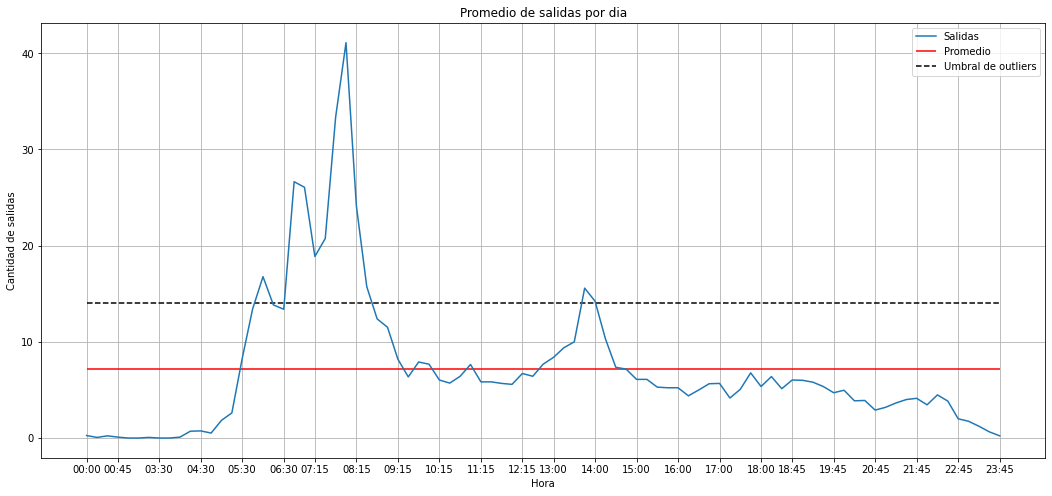

In [16]:
idx = np.linspace(0,len(df2)-1,24).astype(int)
t_labels = df2["INTERVALO"].values[idx]
dia = "Día 1"
#y = df2[dia]
y = prom_salidas_dia

fig, ax =plt.subplots(figsize=(18,8));
ax.plot(range(len(y)),y);
ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");
ax.hlines(y=14, xmin=0, xmax=len(y)-1,color="k",linestyles="dashed");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_xlabel("Hora");
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Promedio de salidas por dia");
ax.legend(["Salidas","Promedio","Umbral de outliers"]);

In [17]:
print("Descripción estadística de salidas promedio por día:")
pd.Series(prom_salidas_dia).describe()

Descripción estadística de salidas promedio por día:


count    89.000000
mean      7.227256
std       7.330960
min       0.000000
25%       3.451613
50%       5.677419
75%       7.903226
max      41.096774
dtype: float64

Vemos que en las primeras y últimas horas del día la cantidad de salidas es casi nula como es de esperarse considerando los horarios de servicio de Transmilenio. Por otro lado, se ve que desde las 5:00 am aproximádamente empieza a crecer considerablemente las salidas (de 0 a 17 salidas entre las 4 y las 6 am). Luego, hay una ligera disminución y a las 6 30 hay un segundo pico que llega hasta 27 salidas. Más adelante vuelve haber un pico máximo alrededor de 41 salidas las 8:30 am, 9:00 am y luego hay un valle entre las 9 y la 1:30 pm. A la  1:45, aumentan de nuevo las salidas (de 8 a 15) y vuelve a disminuir a disminuir a unas 8 salidas. Poco a poco las salidas disminuyen hasta el final del día.

Realicemos análisis de la distribución de los puntos para detectar outliers.

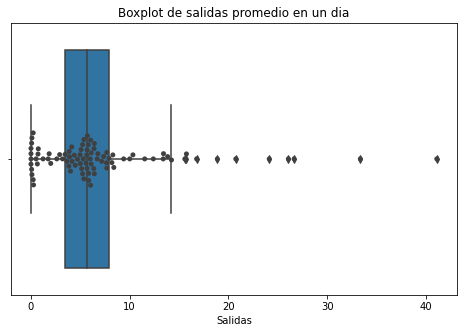

In [18]:
#plt.boxplot(prom_salidas_dia)
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x=prom_salidas_dia);
sns.swarmplot(x=prom_salidas_dia, color=".25");
ax.set_xlabel("Salidas")
ax.set_title("Boxplot de salidas promedio en un dia");

Según el boxplot, los  outliers de esta serie son aquellos en los que la cantidad de salidas es igual o superior a 14. Con la gráfica de arriba confirmamos que en efecto, los valores superiores a 14 corresponden a los que forman los picos de 6:00 a 8:00 am y de 1:30 pm a 2:00 pm.

### 1. Visualizar suavizado con media y comparar con valor verdadero.

In [19]:
# Rolling average transform
win_size=2
prom_salidas_dia = pd.Series(prom_salidas_dia)
rolling = prom_salidas_dia.rolling(window=win_size)
rolling_mean = rolling.mean()

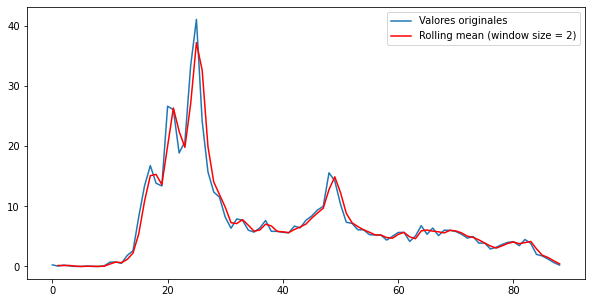

In [20]:
fig = plt.figure(figsize=(10,5));
prom_salidas_dia.plot();
rolling_mean.plot(color='red');
plt.legend(["Valores originales","Rolling mean (window size = "+str(win_size)+')']);

Haciendo varias pruebas parece que el mejor tamaño de la ventana para suavizar sin desviarse es con 2 muestras.

### 2. Visualizar histograma

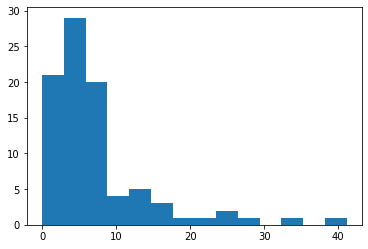

In [21]:
plt.hist(prom_salidas_dia,bins=14);

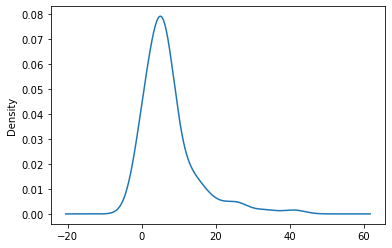

In [22]:
prom_salidas_dia.plot(kind='kde');

No es posible que haya datos negativos por lo cual es mejor considerar una funcion de distribución cuya cola sea más larga del lado derecho. Puede que sea una distribución Beta($p,q$) con $p < q$.

### 3. Visualizar autocorrelación

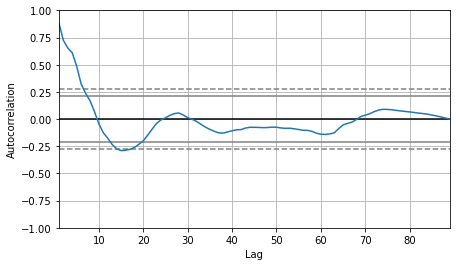

In [23]:
#  create an autocorrelation plot
plt.figure(figsize=(7,4));
autocorrelation_plot(prom_salidas_dia);
plt.grid(True);

<Figure size 864x432 with 0 Axes>

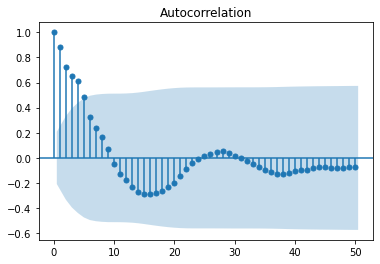

In [24]:
# autocorrelation plot of time series as a line plot
plt.figure(figsize=(12,6));
plot_acf(prom_salidas_dia, lags=50);

Parece que del primer hasta el 5to lag aproximadamente se tiene una auto correlación entre 0.25 y 0.8. Como cada intervalo es de 15 minutos (a excepción de 1 a 3 am) esto significaría que **la 1h y 15 minutos anteriores son los más relevantes para pronosticar cual va a ser la cantidad de salidas en los próximos 15 minutos**.

Ahora repitamos el mismo análisis de análisis pero para la cantidad total de salidas en una estación durante un mes específico.
Adicional a esto, realicemos una prueba de raíz unitaria con un test (aumentado) de Dickey-Fuller. El objetivo de este test es determinar si la serie de tiempo tiene alguna estructura dependiente en el tiempo.

### Análisis para una sola estación
Nuevamente para este análisis, la estación que se va a analizar es el Portal ElDorado en un mes determinado.

In [25]:
# Primero buscamos los registros del Portal ElDorado en Enero y sumamos los registros en todos los accesos
mes = "Enero"
estacion = "(06000) Portal Eldorado"
df3 = df[(df["Estación"]==estacion) & (df["Mes"]==mes)]

In [26]:
df3.head()

,Zona,Estación,Acceso de Estación,Mes,INTERVALO,Día 1,Día 2,Día 3,Día 4,Día 5,...,Día 23,Día 24,Día 25,Día 26,Día 27,Día 28,Día 29,Día 30,Día 31,Total general
0,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:00,6,0.0,10.0,29.0,7.0,...,12.0,12.0,24.0,26.0,2.0,2.0,5.0,10,18,392.0
1,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:15,10,0.0,6.0,7.0,2.0,...,8.0,2.0,7.0,1.0,0.0,10.0,9.0,4,3,152.0
2,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:30,7,0.0,1.0,0.0,8.0,...,0.0,3.0,4.0,12.0,0.0,0.0,0.0,0,1,67.0
3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,00:45,3,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,30.0
4,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,Enero,01:00,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


In [27]:
df3["Acceso de Estación"].value_counts()

(02) PLAT1 ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADO ALAMOS/VILLAAMALIA          89
(04) Acceso Peatonal Occidental                                                                          89
(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO/VILLEMAR/CALIHAYUELOS/LAESTANCIA/ZONA FRANCA/BELÉN-TC6    89
(17) P1ALIM-ENGATIVÁ/LAFAENA/TIERRAGRATA/AEROPUERTO/ELMUELLE/AV.ELDORADOALAMOS/VILLAAMALIA(DISCAP)       89
(19) Acceso Peatonal Occidental (Discapacidad)                                                           89
(03) Acceso Peatonal Oriental                                                                            89
(18) Acceso Peatonal Oriental (Discapacidad)                                                             89
(24) Acceso Bicicletero                                                                                  88
CENTRO                                                                                                   88
(16) P2 A-D FONTIBÓN/FONTIBÓ

In [28]:
# Primero validemo por que algunos accesos tienen 89 registros y otros 88
# Comparemos los intervalos entre el acceso (17) y el acceso CENTRO
df3_1 = df3[df3["Acceso de Estación"].str.contains("(17)")]
df3_2 = df3[df3["Acceso de Estación"]=="CENTRO"]

C:\Users\juanc\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [29]:
list(df3_1["INTERVALO"])

['00:00',
 '00:15',
 '00:30',
 '00:45',
 '01:00',
 '03:00',
 '03:15',
 '03:30',
 '03:45',
 '04:00',
 '04:15',
 '04:30',
 '04:45',
 '05:00',
 '05:15',
 '05:30',
 '05:45',
 '06:00',
 '06:15',
 '06:30',
 '06:45',
 '07:00',
 '07:15',
 '07:30',
 '07:45',
 '08:00',
 '08:15',
 '08:30',
 '08:45',
 '09:00',
 '09:15',
 '09:30',
 '09:45',
 '10:00',
 '10:15',
 '10:30',
 '10:45',
 '11:00',
 '11:15',
 '11:30',
 '11:45',
 '12:00',
 '12:15',
 '12:30',
 '12:45',
 '13:00',
 '13:15',
 '13:30',
 '13:45',
 '14:00',
 '14:15',
 '14:30',
 '14:45',
 '15:00',
 '15:15',
 '15:30',
 '15:45',
 '16:00',
 '16:15',
 '16:30',
 '16:45',
 '17:00',
 '17:15',
 '17:30',
 '17:45',
 '18:00',
 '18:15',
 '18:30',
 '18:45',
 '19:00',
 '19:15',
 '19:30',
 '19:45',
 '20:00',
 '20:15',
 '20:30',
 '20:45',
 '21:00',
 '21:15',
 '21:30',
 '21:45',
 '22:00',
 '22:15',
 '22:30',
 '22:45',
 '23:00',
 '23:15',
 '23:30',
 '23:45']

In [30]:
list(df3_2["INTERVALO"])

['00:00',
 '00:15',
 '00:30',
 '00:45',
 '03:00',
 '03:15',
 '03:30',
 '03:45',
 '04:00',
 '04:15',
 '04:30',
 '04:45',
 '05:00',
 '05:15',
 '05:30',
 '05:45',
 '06:00',
 '06:15',
 '06:30',
 '06:45',
 '07:00',
 '07:15',
 '07:30',
 '07:45',
 '08:00',
 '08:15',
 '08:30',
 '08:45',
 '09:00',
 '09:15',
 '09:30',
 '09:45',
 '10:00',
 '10:15',
 '10:30',
 '10:45',
 '11:00',
 '11:15',
 '11:30',
 '11:45',
 '12:00',
 '12:15',
 '12:30',
 '12:45',
 '13:00',
 '13:15',
 '13:30',
 '13:45',
 '14:00',
 '14:15',
 '14:30',
 '14:45',
 '15:00',
 '15:15',
 '15:30',
 '15:45',
 '16:00',
 '16:15',
 '16:30',
 '16:45',
 '17:00',
 '17:15',
 '17:30',
 '17:45',
 '18:00',
 '18:15',
 '18:30',
 '18:45',
 '19:00',
 '19:15',
 '19:30',
 '19:45',
 '20:00',
 '20:15',
 '20:30',
 '20:45',
 '21:00',
 '21:15',
 '21:30',
 '21:45',
 '22:00',
 '22:15',
 '22:30',
 '22:45',
 '23:00',
 '23:15',
 '23:30',
 '23:45']

El registro de 1 am no está para el acceso de la estación 'CENTRO'. Aunque es un valor que no tiene mucha relevancia porque a esa hora ya no debería haber actividad, por rigurosidad sería bueno insertar ese registro con valor igual a 0 o igual al promedio de los valores vecinos para que todos los accesos tengan 89 registros.Adicionalmente, se debería hacer una verificación de que en los otros accesos el valor que falta sea a la misma hora, pero el método de corrección es análogo.

Para hacer un análisis más rápido se considerará los accesos con todos los 89 registros.

In [31]:
df_pED = df3[df3["Acceso de Estación"].str.contains("(17)|(02)|(18)|(03)|(19)|(04)|(01)")]
df_pED = df_pED.astype({"Día 30":float, "Día 31":float})

In [32]:
accesos = set(df_pED["Acceso de Estación"].values)
salidas_totales = np.zeros(89*31)
for acc in accesos:
    df_aux = df_pED[df_pED["Acceso de Estación"]==acc]
    for i in range(1,32):
        salidas_totales[(i-1)*89:i*89] += df_aux["Día "+str(i)]
#    salidas_totales += df_pED["Total general"].values[89*i:89*(i+1)]
salidas_totales = salidas_totales.astype(int)

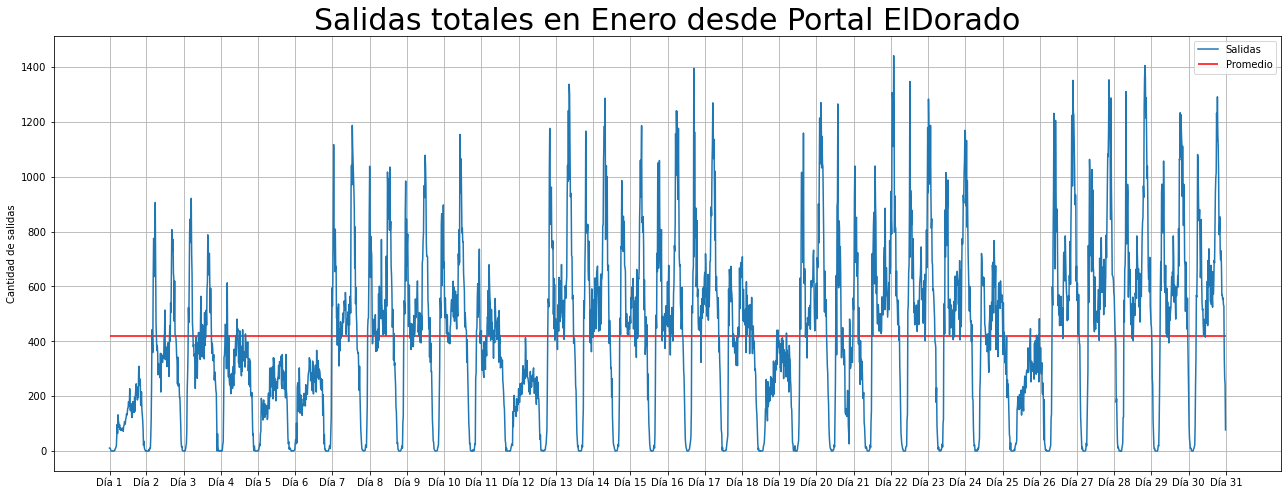

In [33]:
idx = np.linspace(0,89*31,31).astype(int)
t_labels = ["Día "+str(i) for i in range(1,32)]
y = salidas_totales;

fig, ax =plt.subplots(figsize=(22,8));
ax.plot(range(len(y)),y);
ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Salidas totales en Enero desde Portal ElDorado", fontsize=30);
ax.legend(["Salidas","Promedio"]);

In [34]:
print(y.mean())

417.5762957593331


- **En todo el mes:** el promedio de salidas En el portal Eldorado en enero es de 417. Claramente hay un ciclo semanal con picos por día. Aunque en la primera semana parece que el nivel (promedio es más pequeño que el resto de las semanas).
- **Por semana:** los días entre semana suelen tener valores más altos de salidas mientras, los sábados un poco menos y el domingo es el día con cantidad de salidas más bajo, a excepción del primer día (1ero de enero) ya que es festivo y probablemente la gente casi no se mueve por ser festivo después de fin de año o porque están afuera de la ciudad. Suele haber 2 picos por día con un comportamiento con un pico alrededor del medio día no tan alto como los dos que se encuentran al comienzo y final de cada día.
- **Por día**: Adicionalmente a los picos también puede haber patrones inusuales con mínimos como se ve para el 21 de enero. En ese caso, la cantidad baja de salidas se debe a que ese día se declaró paro nacional por lo cual hubo muy pocas personas que utilizaron el Transmilenio ese día
**Conclusiones**: Los patrones por semana son muy similares por lo cual es mejor hacer un **análisis a escala semanal**. Del mismo modo vale la pena **analizar patrones a escala diaria**. También se podría analizar patrones para días específicos de la semana.

Tomemos de ejemplo la 3era semana de Enero

In [35]:
# TERMINAR FUNCION PARA ACCESOS EN PLATAFORMA CON VALORES DISTINTOS A 89 REGISTROS O COLUMNAS CON X EN Día 30/31
def get_station_data(estacion,mes,dia1=1,dia2=31):
    """
    Consigue la suma de todas las salidas en una estacion en un determinado mes entre 2 fechas especificas de ese mes
    
    args:
        estacion: nombre de la estacion
        mes: string del nombre del mes en el que se quiere conseguir los datos
        dia1: string del dia limite inferior incluido
        dia2: string del dia limite inferior incluido
        
    returns:
        arreglo con valores entre las fechas especificadas
    """
    # Primer filtro del nombre de la estacion y mes de interes
    df_aux = df[(df["Estación"]==estacion) & (df["Mes"]==mes)]
    df_aux = df_aux.astype({"Día 30":float, "Día 31":float})
    val_counts = df_aux["Acceso de Estación"].value_counts()
    # Conseguimos todos los nombres de accesos donde haya 89 registros por dia
    valid_access = df_aux["Acceso de Estación"].value_counts().index[np.where(val_counts==89)]
    salidas_totales = np.zeros(89*(dia2-(dia1-1))) # Asumiendo que el formato de los datos es correcto en los 31 dias
    for acc in valid_access:
        # Busqueda de los registros por acceso de la estacion
        df_aux_2 = df_aux[df_aux["Acceso de Estación"]==acc]
        #print(df_aux_2.shape)
        c=0
        for i in range(dia1,dia2+1):
            salidas_totales[c*89:(c+1)*89] += df_aux_2["Día "+str(i)]
            c+=1
    salidas_totales = salidas_totales.astype(int)
    return salidas_totales

In [36]:
d1=13
d2=18
m="Enero"
salidas = get_station_data("(03000) Portal Suba",mes=m,dia1=d1,dia2=d2)
idx = np.linspace(0,89*(d2-(d1-1)),d2-(d1-1)).astype(int)
t_labels = ["Día "+str(i) for i in range(d1,d2+1)]

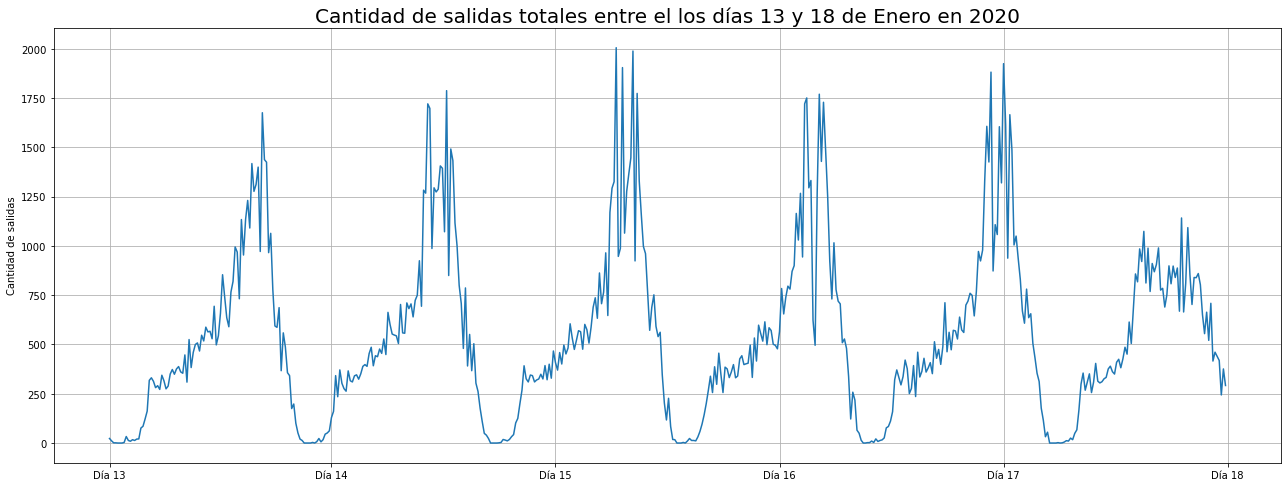

In [37]:
fig, ax =plt.subplots(figsize=(22,8));
ax.plot(range(len(salidas)),salidas);
#ax.hlines(y=y.mean(), xmin=0, xmax=len(y)-1,color="r");

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Cantidad de salidas totales entre el los días "+str(d1) + " y "+str(d2)+" de "+m + " en 2020",fontsize=20);
#ax.legend(["Salidas","Promedio"]);

In [38]:
result = seasonal_decompose(salidas, model='additive', period=89)

In [39]:
def plot_decomposition(res,idx,t_labels):
    """
    Grafica la descomposición de una serie de tiempo
    
    args:
        res: serie de tiempo con los resultados de la descomposición.
    """
    # Observed
    fig,ax = plt.subplots(4,1,figsize=(15,10));
    ax[0].grid(True)
    ax[0].plot(result.observed);
    ax[0].set_title("Observed");
    
    # Trend
    ax[1].grid(True)
    ax[1].plot(result.trend);
    ax[1].set_title("Trend");
    
    # Seasonal
    ax[2].grid(True)
    ax[2].plot(result.seasonal);
    ax[2].set_title("Seasonal");
    
    # Residual
    ax[3].grid(True)
    ax[3].plot(result.resid);
    ax[3].set_title("Residual");
    
    ax[0].set_xticks(idx);
    ax[0].set_xticklabels(t_labels);
    ax[1].set_xticks(idx);
    ax[1].set_xticklabels(t_labels);
    ax[2].set_xticks(idx);
    ax[2].set_xticklabels(t_labels);
    ax[3].set_xticks(idx);
    ax[3].set_xticklabels(t_labels);

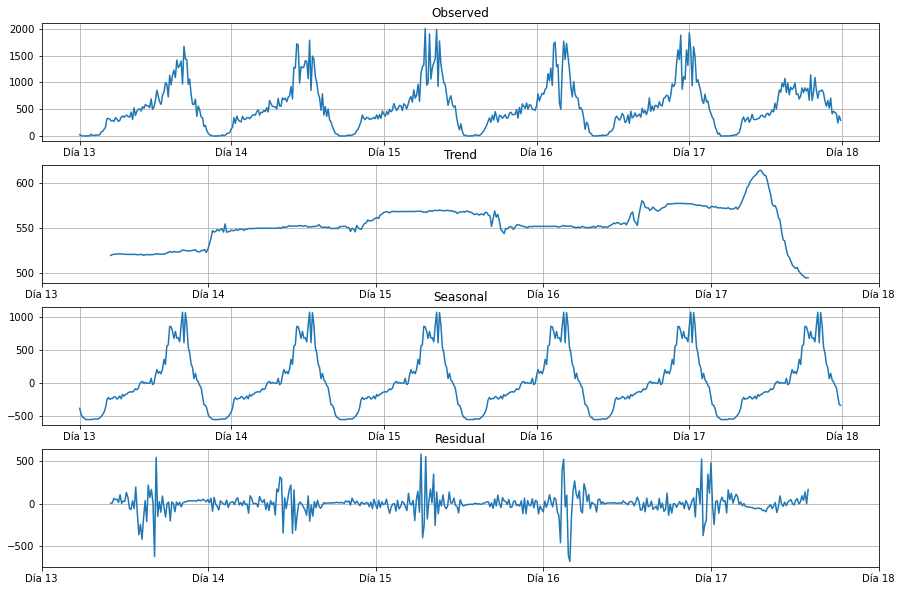

In [40]:
plot_decomposition(result,idx,t_labels)

Text(0.5, 1.0, 'histograma de frecuencias')

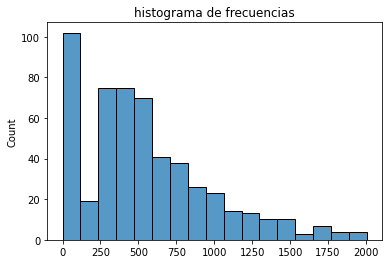

In [41]:
#plt.hist(salidas,bins=12);
sns.histplot(salidas);
plt.title("histograma de frecuencias")

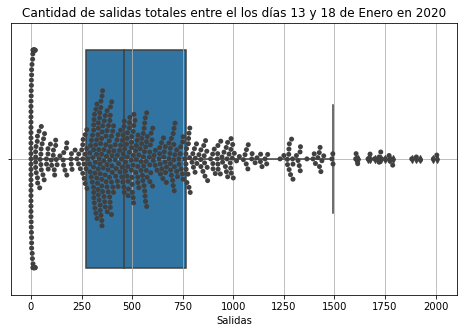

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x=salidas);
sns.swarmplot(x=salidas, color=".25");
ax.set_xlabel("Salidas")
ax.grid(True);
ax.set_title("Cantidad de salidas totales entre el los días "+str(d1) + " y "+str(d2)+" de "+m + " en 2020");

In [43]:
salidas[(salidas>1500)]

array([1676, 1721, 1698, 1788, 2006, 1905, 1989, 1774, 1721, 1751, 1770,
       1729, 1607, 1882, 1605, 1925, 1615, 1666])

Hay muchos valores en 0 por las primeras y últimas horas del día. Los valores entre el cuartil 1 y el cuartil 3 están entre 270 y 520 aproximadamente. Hay una cola larga entre el cuartil 3 y el 4 (1500 salidas) debido a que hay una gran cantidad de valores en ese rango. Por último, los valores superiores a 1500 salidas parecen ser outliers, respectivamente los máximos asociados a las horas picos con salidas máximas.

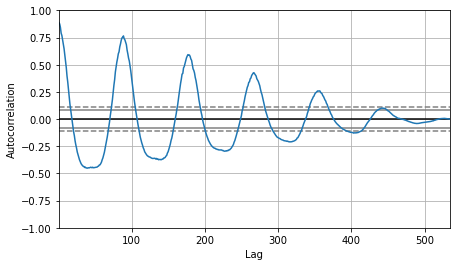

In [44]:
plt.figure(figsize=(7,4));
autocorrelation_plot(salidas);
plt.grid(True);

<Figure size 864x432 with 0 Axes>

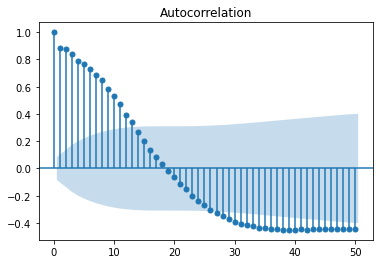

In [45]:
plt.figure(figsize=(12,6));
plot_acf(salidas, lags=50);

La autocorrelación oscilatoria puede deberse a un comportamiento estacional, probablemente entre días. En tanto a los lags, parece que lo mejor es considerar hasta 14 lags ya que según la gráfica , con los primeros 14 hay una autocorrelación superior a 0.4.

## Test Aumentado de Dickey-Fuller
- Hipótesis nula: La serie tiene raíz unitaria, serie es estacionaria, por lo tanto, dificultades para estimaciones.
- Hipótesis alternativa:(con p-valor menor a valores críticos) la serie no tiene raíz unitaria. Entre más negativo el estadistico ADF más se rechaza la hipótesis.

La presencia de raíz unitaria nos hace creer un estimador es significante (bueno) para la regresión cuando en realidad no lo es.

**Wikipedia:**

En estadística y econometría, una prueba de Dickey-Fuller aumentada (ADF) es una prueba de raíz unitaria para una muestra de una serie de tiempo. Es una versión aumentada de la prueba Dickey-Fuller para un conjunto más amplio y más complejo de modelos de series de tiempo. La estadística Dickey-Fuller Aumentada (ADF), utilizada en la prueba, es un número negativo. Cuanto más negativo es, más fuerte es el rechazo de la hipótesis nula de que existe una raíz unitaria para un cierto nivel de confianza.

In [46]:
X = salidas
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.500718
p-value: 0.000002
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


Se rechaza la hipótesis nula, por lo tanto no hay raíz unitaria, la serie es estacionaria.

## Agrupamiento de Series
- Conseguir información de todas las salidas por estación y agruparlas en un solo dataset (Todas van a tener la misma cantidad de datos).
- Aplicar agrupación jerárquica

In [47]:
# Primero conseguir el nombre de todas las estaciones de transmilenio
# Luego se itera sobre cada estacion y se consigue la cantidad de salidas en el mes e intervalo de salidas especificado
# Se concatena todos los arreglos en un dataframe
estaciones = list(set(df["Estación"]))
print("Cantidad de estaciones: ",len(estaciones))
# Informacion para query
d1=13
d2=18
m="Enero"
#salidas = get_station_data("(03000) Portal Suba",mes=m,dia1=d1,dia2=d2)
idx = np.linspace(0,89*(d2-(d1-1)),d2-(d1-1)).astype(int)
t_labels = ["Día "+str(i) for i in range(d1,d2+1)]
mat = []
for e in estaciones:
    s = get_station_data(e,mes=m,dia1=d1,dia2=d2)
    mat.append(s.reshape([len(s),1]))


Cantidad de estaciones:  159


In [48]:
df_salidas_estacion = pd.DataFrame(np.concatenate(mat,axis=1),columns=estaciones)
df_salidas_estacion.head()

,(04105) Carrera 53,(14005) Las Aguas,(50003) Corral Molinos,(06105) Quinta Paredes,(03005) SUBA - AV. BOYACA,(07110) PALOQUEMAO,(09113) Calle 22,(09117) Calle 45,(10002) Av. Primero de Mayo,(02205) Calle 106,...,(08002) Biblioteca,(04004) La Granja,(09109) Tercer Milenio,(50002) Corral Calle 40 Sur,(06002) Normandía,(07002) MADELENA,(03004) GRATAMIRA,(02200) Alcalá,(02105) Calle 142,(04108) El Polo
0,0,0,0,0,1,0,1,0,4,0,...,0,0,0,3,1,0,0,3,0,0
1,0,2,0,0,0,0,0,1,2,0,...,3,0,0,0,0,2,0,0,1,0
2,1,0,1,0,0,0,0,2,4,0,...,1,0,0,0,0,1,0,0,1,1
3,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


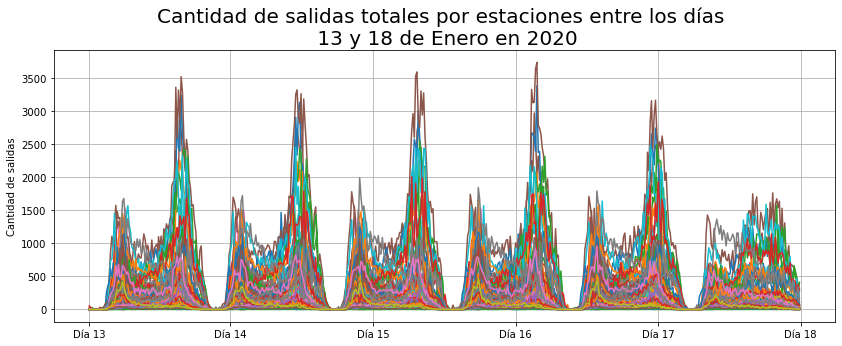

In [49]:
#fig = plt.figure(figsize=(10,7))
#plt.plot(df_salidas_estacion.iloc[:,:10]);
#plt.legend(estaciones[:10]);
#plt.grid(True);

fig, ax =plt.subplots(figsize=(14,5));
ax.plot(range(len(df_salidas_estacion)),df_salidas_estacion);

ax.set_xticks(idx)
ax.set_xticklabels(t_labels)
ax.grid(True)
ax.set_ylabel("Cantidad de salidas");
ax.set_title("Cantidad de salidas totales por estaciones entre los días \n "+str(d1) + " y "+str(d2)+" de "+m + " en 2020",\
             fontsize=20);
#ax.legend(estaciones[:10]);

El agrupamiento de series se hace con **Dynamic Time Warping** (DTW).

In [50]:
df_salidas_estacion.isna().sum()

(04105) Carrera 53           0
(14005) Las Aguas            0
(50003) Corral Molinos       0
(06105) Quinta Paredes       0
(03005) SUBA - AV. BOYACA    0
                            ..
(07002) MADELENA             0
(03004) GRATAMIRA            0
(02200) Alcalá               0
(02105) Calle 142            0
(04108) El Polo              0
Length: 159, dtype: int64

In [51]:
# Filtremos las columnas que son 0.
# Algunas no tienen valores quizas porque se excluyeron los accesos
# en los que habia menos de 89 registros al dia y puede que en esos si hubiera datos 
estaciones_z = [df_salidas_estacion.columns[i] for i in range(df_salidas_estacion.shape[1]) if np.all(df_salidas_estacion.iloc[:,i]==0)]
# Eliminamos estas estaciones (no deberia hacerse para conserar datos, por ahora si)
df_salidas_estacion = df_salidas_estacion.drop(columns=estaciones_z)
df_salidas_estacion.shape

(534, 156)

In [52]:
# Con la columna 11 hay nans
distance_matrix = df_salidas_estacion.corr()

In [53]:
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

In [54]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

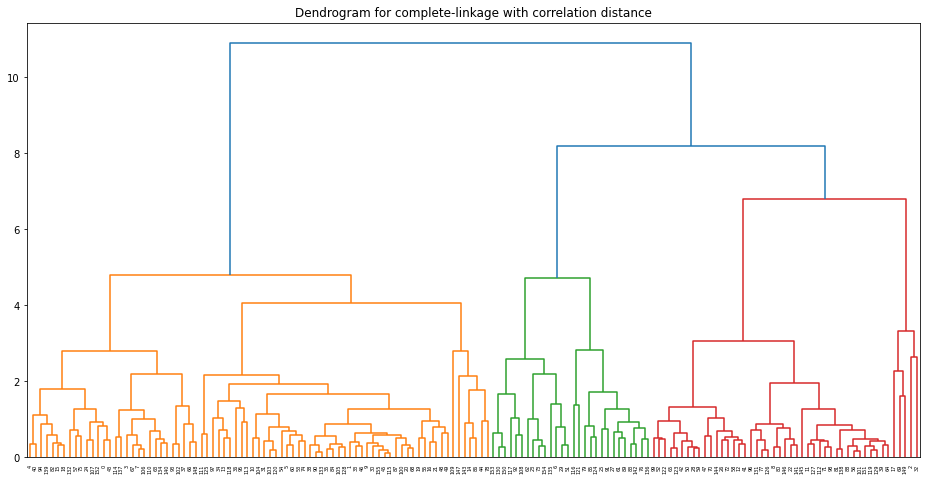

In [55]:
linkage_matrix = hierarchical_clustering(distance_matrix)

In [56]:
from scipy.cluster.hierarchy import fcluster
"""
# select maximum number of clusters
cluster_labels = fcluster(linkage_matrix, 4, criterion='maxclust')
print(np.unique(cluster_labels))
#>> 4 unique clusters
cluster_labels = fcluster(linkage_matrix, 10, criterion='maxclust')
print(np.unique(cluster_labels))
#>> 10 unique clusters
"""
# hand-select an appropriate cut-off on the dendrogram
cluster_labels = fcluster(linkage_matrix, 7.5, criterion='distance')
print(np.unique(cluster_labels))
#>> 3 unique clusters
#cluster_labels = fcluster(linkage_matrix, 800, criterion='distance')
#print(np.unique(cluster_labels))
#>> 2 unique clusters

[1 2 3]


In [57]:
clusters = dict()
for i in np.unique(cluster_labels):
    clusters[i] = df_salidas_estacion.columns[cluster_labels==i]

In [58]:
print("Cluster 1:")
print(clusters[1])
print("==========================================")

print("Cluster 2:")
print(clusters[2])
print("==========================================")

print("Cluster 3:")
print(clusters[3])

Cluster 1:
Index(['(04105) Carrera 53', '(14005) Las Aguas', '(06105) Quinta Paredes',
       '(03005) SUBA - AV. BOYACA', '(07110) PALOQUEMAO', '(09117) Calle 45',
       '(02205) Calle 106', '(10007) Las Nieves', '(12007) Zona Industrial',
       '(02303) Calle 85', '(07201) Guatoque -Veraguas', '(09122) Calle 72',
       '(04106) Carrera 47', '(05105) Pradera', '(04107) Escuela Militar',
       '(02202) Calle 127', '(06100) Av. Rojas', '(07108) Av. El Dorado',
       '(07101) CASTELLANA', '(06101) El Tiempo', '(12000) Puente Aranda',
       '(03009) Av. Suba- Calle 116', '(02204) Pepe Sierra',
       '(09108) Hospital', '(10008) San Diego', '(06001) Modelia',
       '(04103) Las Ferias', '(02302) Virrey', '(03013) RIO NEGRO',
       '(09121) Las Flores', '(03012) SUBA - CALLE 95',
       '(05107) Américas - Cr.53', '(07104) Simon Bolivar', '(09123) Calle 76',
       '(03006) NIZA - CALLE 127', '(09107) Hortúa', '(07111) NQS - RICAURTE',
       '(04104) Avenida 68', '(09111) Calle 19

In [59]:
# Grafiquemos las series de cada cluster
cluster_estaciones_1 = df_salidas_estacion[clusters[1]]
cluster_estaciones_2 = df_salidas_estacion[clusters[2]]
cluster_estaciones_3 = df_salidas_estacion[clusters[3]]

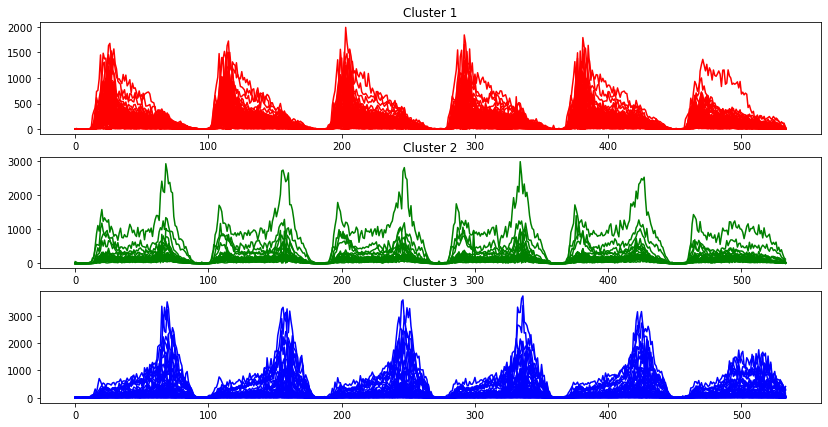

In [60]:
fig, ax = plt.subplots(3,1,figsize=(14,7))
ax[0].plot(cluster_estaciones_1,color="r");
ax[0].set_title("Cluster 1");

ax[1].plot(cluster_estaciones_2,color="g");
ax[1].set_title("Cluster 2");

ax[2].plot(cluster_estaciones_3,color="b");
ax[2].set_title("Cluster 3");

## Ubicando información de estaciones geograficamente

In [81]:
def get_station_codes(df):
    codigos = []
    for col in df.columns:
        left_p = False
        right_p = False
        cod = ""
        for i in range(len(col)):
            if col[i]=='(':
                left_p = True
                j = i+1
                while not right_p:
                    cod += col[j]
                    j+=1
                    if col[j] == ')':
                        right_p = True
            break
        codigos.append(cod)
    return codigos  

In [82]:
codigos_estaciones = get_station_codes(df_salidas_estacion)
codigos_estaciones

['04105',
 '14005',
 '50003',
 '06105',
 '03005',
 '07110',
 '09113',
 '09117',
 '10002',
 '02205',
 '10007',
 '07010',
 '05101',
 '12007',
 '02303',
 '07201',
 '09122',
 '50004',
 '04106',
 '05105',
 '04107',
 '02202',
 '09003',
 '06000',
 '06100',
 '02000',
 '04002',
 '07003',
 '04003',
 '04102',
 '07108',
 '07101',
 '40004',
 '06101',
 '12000',
 '03009',
 '02204',
 '09108',
 '10008',
 '10000',
 '06001',
 '07008',
 '04001',
 '04103',
 '02302',
 '03013',
 '09121',
 '07006',
 '03012',
 '05107',
 '03002',
 '09105',
 '08001',
 '07104',
 '09123',
 '03006',
 '05001',
 '09107',
 '07004',
 '04000',
 '07111',
 '02104',
 '09103',
 '04104',
 '05000',
 '07506',
 '09111',
 '09119',
 '07107',
 '07504',
 '03003',
 '08000',
 '04100',
 '02103',
 '12003',
 '10010',
 '07009',
 '40001',
 '02300',
 '07005',
 '05100',
 '09000',
 '03007',
 '09104',
 '07103',
 '02001',
 '02304',
 '07105',
 '03001',
 '07113',
 '09115',
 '10005',
 '02101',
 '14001',
 '06107',
 '03014',
 '05005',
 '12002',
 '07000',
 '09101',


In [61]:
path_to_data_bog = "dscat_shp\\scat_shp\\scat.shp"
gdf_bog = gpd.read_file(path_to_data_bog)

In [73]:
path_estaciones = "GTFS-2020-01-24\\stops.txt"
df_estaciones = pd.read_csv(path_estaciones,encoding='latin-1', header=0)
df_estaciones = 
print(df_estaciones.shape)
df_estaciones.head()

(7793, 4)


,stop_id,stop_name,stop_lat,stop_lon
0,09121,Flores,4.654713,-74.063088
1,06106,Corferias,4.634100,-74.089203
2,07504,Terreros - Hospital C.V.,4.590032,-74.197525
3,09103,Olaya,4.578931,-74.107294
4,09101,Quiroga,4.576762,-74.114240


In [126]:
# Busqueda de las estaciones si su coidigo coincide con el codigo de las salidas
filas_est_TM = [np.where(df_estaciones["stop_id"]==codigos_estaciones[i]) for i in range(len(codigos_estaciones))]
filas_TM = [arr[0][0] for arr in filas_est_TM if len(arr[0]) != 0]
df_estaciones = df_estaciones.iloc[filas_TM,:]

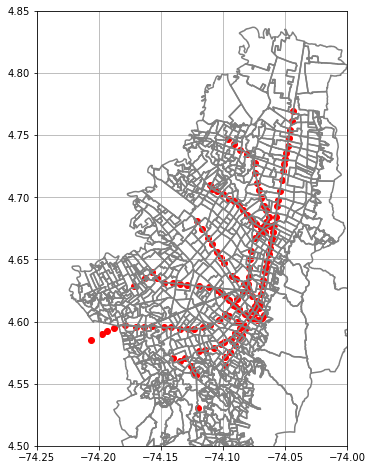

In [131]:
ax = gdf_bog.boundary.plot(figsize=(8,8),color="gray");
minx, miny, maxx, maxy = [-74.25, 4.5, -74, 4.85]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.scatter(df_estaciones["stop_lon"],df_estaciones["stop_lat"],color="r");
plt.grid(True);